In [72]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from IPython.display import Image, display
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.output_parsers import PydanticOutputParser
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator
import asyncio
import json
import uuid
import websockets
from typing import Dict, List, Any, Optional

## tools related libraries 
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [73]:

def llm_with_mcp_demo(user_query: str):
    """return the weather data"""  
    return "27 degree celsius"


In [74]:
# RAG Function
@tool
def function_2(state:MessagesState):
    """this is my custom tool for serving RAG Call. It retrieves relevant documents from the vector store and generates a concise answer based on the retrieved context. This is to be called when Supervisor returns "USA" """
    
    print("-> RAG Call ->")
    
    question = state["messages"][0].content
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    ## return {"messages": [MessagesState(content=result)]}
    return result

In [75]:
# LLM Function
@tool
def function_3(state:MessagesState):
    """this is my custom tool for calling the LLM when neither usa nor weather is the topic. This is to be called when Supervisor returns "Not Related" """ 
    
    print("-> LLM Call ->")
    question = state["messages"][0].content
    
    # Normal LLM call
    complete_query = "Answer the following question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return response.content

In [76]:
# weather tool
@tool
def function_4(state:MessagesState):
    """this is my custom tool for searching a weather. This is to be called when Supervisor returns "Weather" """
    print("-> Weather Call ->")
    question = state["messages"][0].content
    
    # Normal LLM call
    # complete_query = "Answer the follow question with you knowledge of the real # world. Following is the user question: " + question
    #response = model.invoke(complete_query)
    response = llm_with_mcp_demo(question)
    return response

In [77]:
from langchain_openai import ChatOpenAI
model=ChatOpenAI(model='gpt-3.5-turbo')
output = model.invoke("can you tell me about the india's capital?")
print(output.content)

India's capital is New Delhi, which serves as the seat of the Government of India. It is located in the northern part of the country and is a bustling metropolis known for its rich history, diverse culture, and vibrant atmosphere. New Delhi is home to important government buildings, including the Parliament House, the Presidential Residence (Rashtrapati Bhavan), and the Prime Minister's Office. The city is also known for its iconic landmarks such as India Gate, Qutub Minar, Lotus Temple, and Humayun's Tomb. New Delhi is a major political, cultural, and economic center in India, attracting visitors from around the world.


In [78]:
tools=[function_2, function_3, function_4]
llm_with_tool=model.bind_tools(tools)

In [79]:
# configuring the embedding model
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en"
)

c:\Users\samra\anaconda3\envs\agentic_2_base\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [80]:
loader=DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()

In [81]:
## chunk size to be lesser than context window size of the model
## overlapping is not necessary if there are logic delimiter in the text. if there is a passage that is related to each other, without headers etc. in that case overlapping is useful. 
## heirarchical chunking helps to keep the heirarchical structure of the text, so that the model can understand the context better.
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [82]:
new_docs=text_splitter.split_documents(documents=docs)

In [83]:
print(new_docs)

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'), Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'), Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a'), Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.'), Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='innovation, global trade, and

In [84]:
doc_string=[doc.page_content for doc in new_docs]
print(doc_string)

['🇺🇸 Overview of the U.S. Economy', 'The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,', 'It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a', 'a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.', 'innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.', 'U.S. GDP – Size, Composition, and Global Share', 'As of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of

In [85]:
db=Chroma.from_documents(new_docs,embeddings)

In [86]:
len(embeddings.embed_query("hello world"))

384

In [87]:
retriever=db.as_retriever(search_kwargs={"k": 3})

In [88]:
retriever.invoke("industrial growth of usa?")

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy')]

In [89]:
from pydantic import BaseModel, Field

In [90]:
# pydantic class 
class TopicSelectionParser(BaseModel):
    topic: str = Field(description ="The topic to be selected for the workflow")
    reasoning: str = Field(description="The reasoning behind the topic selection")

In [91]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [92]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"topic": {"description": "The topic to be selected for the workflow", "title": "Topic", "type": "string"}, "reasoning": {"description": "The reasoning behind the topic selection", "title": "Reasoning", "type": "string"}}, "required": ["topic", "reasoning"]}\n```'

In [93]:
## The LLM will automatically classify and spit out the category name as mentioned in the template. 
def function_1(state:MessagesState):
    """Router that triggers appropriate tool calls"""
    
    question = state["messages"][-1].content
    print(f"function_1 is called with question: {question}")
    
    # Create a prompt that will make LLM decide which tool to call
    tool_prompt = f"""You need to help answer this question: {question}

You have access to these tools:
- function_2: For USA-related questions (GDP, economy, etc.)
- function_3: For general knowledge questions
- function_4: For weather-related questions

Please call the appropriate tool to answer the question.

CRITICAL: Call EXACTLY ONE tool. Choose the MOST RELEVANT tool and call ONLY that tool. 
Do not call multiple tools."""
    
    # Use LLM with tools to decide which tool to call
    response = llm_with_tool.invoke([HumanMessage(content=tool_prompt)])
    
    return {"messages": [response]}  # This will have tool_calls if LLM decides to use tools

In [94]:
state : MessagesState = MessagesState(messages=[HumanMessage(content="what is today's weather?")])
print (state)

{'messages': [HumanMessage(content="what is today's weather?", additional_kwargs={}, response_metadata={})]}


In [ ]:
## since function_1 is tools annotated, the final message will show null. it will only return toolMessage to the LLM within the workflow. 
function_1(state)

function_1 is called with question: what is today's weather?


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_G3uD8PD9qBPq43MqCyKHAjmx', 'function': {'arguments': '{"state":{"messages":[{"content":"What is today\'s weather?","type":"human"}]}}', 'name': 'function_4'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 9961, 'total_tokens': 9991, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bytfx4vJgUulC6zBtRiOcPE0GcOsy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bfb3f56b-a594-44e6-9ae7-dac1b48f66e7-0', tool_calls=[{'name': 'function_4', 'args': {'state': {'messages': [{'content': "What is today's weather?", 'type': 'human'}]}}, 'id': 'call_G3uD8PD9qBPq43MqCyKHAjmx', '

In [96]:
state={"messages":[HumanMessage(content="what is the GDP of USA?")]}

In [97]:
response = function_1(state)
print (response)

function_1 is called with question: what is the GDP of USA?
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rdNPXmYuyO4gkmLAuIX3cHDm', 'function': {'arguments': '{"state":{"messages":[{"content":"What is the GDP of USA?"}]}}', 'name': 'function_2'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 9962, 'total_tokens': 9988, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bytg0WaQVtgCt9IM5NZ3IODrMVoZL', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f6f11940-da28-45c2-8677-3a51a512174b-0', tool_calls=[{'name': 'function_2', 'args': {'state': {'messages': [{'content': 'What is the GDP of USA?'}]}}, 'id': 'call_rdN

In [98]:
def router(state:MessagesState):
    print ("-> ROUTER -> ")

    last_message = state["messages"][-1]
    print (f"Last message: {last_message}")

    if last_message.tool_calls:
        return "tools"
    return END
    

In [99]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [100]:
response=llm_with_tool.invoke("what is a weather is delhi?")

In [101]:
response.content

''

In [102]:
response.tool_calls

[{'name': 'function_4',
  'args': {'state': {'messages': [{'content': 'what is a weather is delhi?',
      'type': 'human'}]}},
  'id': 'call_yyCuCCPpFgSbkgqsi9RrTLWq',
  'type': 'tool_call'}]

In [103]:
from langgraph.prebuilt import ToolNode

tool_node=ToolNode(tools)

In [104]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'function_2': StructuredTool(name='function_2', description='this is my custom tool for serving RAG Call. It retrieves relevant documents from the vector store and generates a concise answer based on the retrieved context. This is to be called when Supervisor returns "USA"', args_schema=<class 'langchain_core.utils.pydantic.function_2'>, func=<function function_2 at 0x000001AF93AA5A80>), 'function_3': StructuredTool(name='function_3', description='this is my custom tool for calling the LLM when neither usa nor weather is the topic. This is to be called when Supervisor returns "Not Related"', args_schema=<class 'langchain_core.utils.pydantic.function_3'>, func=<function function_3 at 0x000001AF93AA5580>), 'function_4': StructuredTool(name='function_4', description='this is my custom tool for searching a weather. This is to be called when Superviso

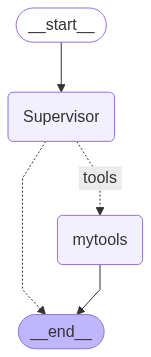

In [105]:
from langgraph.graph import StateGraph,END
workflow=StateGraph(MessagesState)
workflow.add_node("Supervisor",function_1)
workflow.add_node("mytools",tool_node)
workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
    "Supervisor", 
    router,
    {
        "tools": "mytools",
        END:END
    }
)
app=workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [106]:
from langchain_core.messages import HumanMessage
agent_state = MessagesState(messages=[HumanMessage(content="what is the GDP of USA?")])
agent_state = MessagesState(messages=[HumanMessage(content="what is the weather of NYC?")])

print (agent_state)

{'messages': [HumanMessage(content='what is the weather of NYC?', additional_kwargs={}, response_metadata={})]}


In [107]:
app.invoke(agent_state)

function_1 is called with question: what is the weather of NYC?
-> ROUTER -> 
Last message: content='' additional_kwargs={'tool_calls': [{'id': 'call_qveUGTVHYco7etrJNojEopiG', 'function': {'arguments': '{"state":{"messages":[{"content":"What is the weather of NYC?","type":"human"}]}}', 'name': 'function_4'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 9962, 'total_tokens': 9993, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bytg4gbMtosq1SK7YaHrIqV9ReKhe', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--926d1a47-1204-493c-b8cb-19661828998a-0' tool_calls=[{'name': 'function_4', 'args': {'state': {'messages': [{'content': 'What is the weather of

{'messages': [HumanMessage(content='what is the weather of NYC?', additional_kwargs={}, response_metadata={}, id='9b3ca96c-f121-4873-85b8-4dad402f949b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qveUGTVHYco7etrJNojEopiG', 'function': {'arguments': '{"state":{"messages":[{"content":"What is the weather of NYC?","type":"human"}]}}', 'name': 'function_4'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 9962, 'total_tokens': 9993, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bytg4gbMtosq1SK7YaHrIqV9ReKhe', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--926d1a47-1204-493c-b8cb-19661828998a-0', tool_calls=[{'name': 'fu

In [108]:
from langchain_core.messages import HumanMessage
agent_state = MessagesState(messages=[HumanMessage(content="What is the capital of India?")])

print (agent_state)
app.invoke(agent_state)

{'messages': [HumanMessage(content='What is the capital of India?', additional_kwargs={}, response_metadata={})]}
function_1 is called with question: What is the capital of India?
-> ROUTER -> 
Last message: content='' additional_kwargs={'tool_calls': [{'id': 'call_Nnalt53SnDdUGanmnwVj3IbE', 'function': {'arguments': '{"state":{"messages":[{"content":"What is the capital of India?","type":"human"}]}}', 'name': 'function_3'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 9962, 'total_tokens': 9993, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bytg6cp5Uq38gr4SWEEJ5HX0nBNgm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--c05af03d-e2fc-45c4-926b-

{'messages': [HumanMessage(content='What is the capital of India?', additional_kwargs={}, response_metadata={}, id='393b6230-630e-4a13-a0e0-c6be94e0b1a9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Nnalt53SnDdUGanmnwVj3IbE', 'function': {'arguments': '{"state":{"messages":[{"content":"What is the capital of India?","type":"human"}]}}', 'name': 'function_3'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 9962, 'total_tokens': 9993, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bytg6cp5Uq38gr4SWEEJ5HX0nBNgm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c05af03d-e2fc-45c4-926b-832a135b9e36-0', tool_calls=[{'name':

In [109]:
from langchain_core.messages import HumanMessage
agent_state = MessagesState(messages=[HumanMessage(content="What is the weather of NYC?")])

print (agent_state)
app.invoke(agent_state)

{'messages': [HumanMessage(content='What is the weather of NYC?', additional_kwargs={}, response_metadata={})]}
function_1 is called with question: What is the weather of NYC?
-> ROUTER -> 
Last message: content='' additional_kwargs={'tool_calls': [{'id': 'call_Egdf82mqrx8DnYfmoFGQ20AQ', 'function': {'arguments': '{"state":{"messages":[{"content":"What is the weather of NYC?","type":"human"}]}}', 'name': 'function_4'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 9962, 'total_tokens': 9993, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bytg8xrqCqbzFg9tklmLn6xYoDoP4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--f42a7505-2f43-4912-a90d-8d93ce

{'messages': [HumanMessage(content='What is the weather of NYC?', additional_kwargs={}, response_metadata={}, id='fe7c91e9-c3d0-4de1-9ceb-26a6b68e495b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Egdf82mqrx8DnYfmoFGQ20AQ', 'function': {'arguments': '{"state":{"messages":[{"content":"What is the weather of NYC?","type":"human"}]}}', 'name': 'function_4'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 9962, 'total_tokens': 9993, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bytg8xrqCqbzFg9tklmLn6xYoDoP4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f42a7505-2f43-4912-a90d-8d93ceb1b4de-0', tool_calls=[{'name': 'fu

In [110]:
for output in app.stream({"messages": [HumanMessage(content="What is economy of usa?")]
}):
    for key, value in output.items():
        ## key is the name of the node, value is the output of the node
        print("==========================================")
        print(f"here is the output from {key}")
        print ("=========================================")
        print(value)
        print("\n")

function_1 is called with question: What is economy of usa?
-> ROUTER -> 
Last message: content='' additional_kwargs={'tool_calls': [{'id': 'call_5TdzS2UVGU3RGrJDuw5xBdhQ', 'function': {'arguments': '{"state":{"messages":[{"content":"What is economy of usa?","type":"human"}]}}', 'name': 'function_2'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 9961, 'total_tokens': 9991, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BytgAwLlgHEuBKm0fG62eNLgNqtIk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--6ccec2d4-05ef-477c-b996-26b3c9c1aca9-0' tool_calls=[{'name': 'function_2', 'args': {'state': {'messages': [{'content': 'What is economy of usa?', 'typ

### memory setup


In [111]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
app=workflow.compile(checkpointer=memory)
config = {"configurable": {"thread_id":"1"}}

In [112]:
events = app.stream(
    {"messages": [HumanMessage(content="What is economy of usa?")]}, config=config, stream_mode="values")
for event in events:
   event["messages"][-1].pretty_print()

================================ Human Message =================================

What is economy of usa?
function_1 is called with question: What is economy of usa?
-> ROUTER -> 
Last message: content='' additional_kwargs={'tool_calls': [{'id': 'call_t3w1aQYzJh43Egm6m9kpWbs6', 'function': {'arguments': '{"state":{"messages":[{"content":"What is economy of usa?"}]}}', 'name': 'function_2'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 9961, 'total_tokens': 9986, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BytgC4iuAGpscuMONIVm0DAtuUhPY', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--f53b1030-b202-454e-93b7-a2f387e10b65-0' tool_calls=[{'name'

In [113]:
events = app.stream(
    {"messages": [HumanMessage(content="What weather of Phoenix?")]}, config=config, stream_mode="values")
for event in events:
   event["messages"][-1].pretty_print()

================================ Human Message =================================

What weather of Phoenix?
function_1 is called with question: What weather of Phoenix?
-> ROUTER -> 
Last message: content='' additional_kwargs={'tool_calls': [{'id': 'call_RTskhWFghTuDzGJx9jmL9vMl', 'function': {'arguments': '{"state":{"messages":[{"content":"What weather of Phoenix?","type":"human"}]}}', 'name': 'function_4'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 9960, 'total_tokens': 9989, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BytgEOAfNAAGDNO1hYxkNyHi21OSY', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--24a7d20b-c78d-48dc-9fee-e839118ef4e7-0' t

In [114]:
events = app.stream(
    {"messages": [HumanMessage(content="what does Fromm talk about love?")]}, config=config, stream_mode="values")
for event in events:
   event["messages"][-1].pretty_print()

================================ Human Message =================================

what does Fromm talk about love?
function_1 is called with question: what does Fromm talk about love?
-> ROUTER -> 
Last message: content='' additional_kwargs={'tool_calls': [{'id': 'call_xDc1aFZ1DNByJnXg9nPwvaAa', 'function': {'arguments': '{"state": {"messages": [{"content": "what does Fromm talk about love?", "type": "human"}]}}', 'name': 'function_4'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 4096, 'prompt_tokens': 9963, 'total_tokens': 14059, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BytgH3hahJgLISOIaomskNWVTfhwp', 'service_tier': 'default', 'finish_reason': 'length', 'logprobs': None} id='run--023ef967-ef36

In [115]:
memory.get(config)

{'v': 3,
 'ts': '2025-07-30T05:31:43.912614+00:00',
 'id': '1f06d067-a648-6a7c-800a-a167d8fc24da',
 'channel_versions': {'__start__': '00000000000000000000000000000010.0.8090555390291142',
  'messages': '00000000000000000000000000000012.0.6320757859551955',
  'branch:to:Supervisor': '00000000000000000000000000000011.0.8288878578885306',
  'branch:to:mytools': '00000000000000000000000000000012.0.07559163786223022'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000009.0.2997683368101929'},
  'Supervisor': {'branch:to:Supervisor': '00000000000000000000000000000010.0.8390585723506649'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000011.0.5064298560557243'}},
 'channel_values': {'messages': [HumanMessage(content='What is economy of usa?', additional_kwargs={}, response_metadata={}, id='8ce7dc6f-9883-4f31-aa71-4bbea321c525'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_t3w1aQYzJh43Egm6m9kpWbs6', 'fu

In [116]:
events = app.stream(
    {"messages": [HumanMessage(content="what is the economy of usa")]}, config=config, stream_mode="values")

for event in events:
   event["messages"][-1].pretty_print()

================================ Human Message =================================

what is the economy of usa
function_1 is called with question: what is the economy of usa
-> ROUTER -> 
Last message: content='' additional_kwargs={'tool_calls': [{'id': 'call_dZWAkWAkyIUoYZz1W7pe00Vw', 'function': {'arguments': '{"state":{"messages":[{"content":"What is the economy of USA?","type":"human"}]}}', 'name': 'function_2'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 9962, 'total_tokens': 9993, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BytheBqgwyAbZcggBRaM0HrrtuFss', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--6d56f158-a438-4511-88cb-b653cd8ba5

In [117]:
from langgraph.graph import StateGraph,MessagesState,START,END
from langchain_core.messages import HumanMessage, AIMessage

def process_query(query):
    """Process query with streaming to see workflow steps"""
    
    print(f"🔍 Processing query: {query}")
    print("=" * 50)
    
    try:
        # Stream the workflow execution
        events = app.stream(
            {"messages": [HumanMessage(content=query)]}, 
            config=config, 
            stream_mode="values"
        )
        
        step = 0
        for event in events:
            step += 1
            print(f"\n📍 Step {step}:")
            
            if "messages" in event and event["messages"]:
                last_message = event["messages"][-1]
                print(f"📝 {type(last_message).__name__}: {last_message.content}")
        
        print("\n✅ Query processing completed!")
        
    except Exception as e:
        print(f"❌ Error processing query: {str(e)}")
  

In [118]:
from IPython.display import display
import ipywidgets as widgets

def chat_loop():
    print("Type your queries or 'quit' to exit.")
    
    # Create the output area where responses will be shown
    output_area = widgets.Output()
    display(output_area)
    
    def process_input(sender):
        query = input_widget.value
        input_widget.value = ""  # Clear the input box
        
        with output_area:
            print(f"\nQuery: {query}")
            if query.lower() == 'quit':
                print("Exiting chat loop...")
                return
            
            try:
                process_query(query)  # Assuming this function is defined elsewhere
                print("\n")
            except Exception as e:
                print(f"\nError: {str(e)}")
    
    # Create the input widget
    input_widget = widgets.Text(
        placeholder='Type your query here...',
        description='Query:',
        layout=widgets.Layout(width='80%')
    )
    
    # Connect the callback to the 'on_submit' event
    input_widget.on_submit(process_input)
    
    # Display the input widget
    display(input_widget)

In [120]:
chat_loop()

Type your queries or 'quit' to exit.


Output()

C:\Users\samra\AppData\Local\Temp\ipykernel_19120\2325932585.py:35: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_widget.on_submit(process_input)


Text(value='', description='Query:', layout=Layout(width='80%'), placeholder='Type your query here...')